In [1]:
# in this notebook I'll be implementing a shallow neural network
# it's input will be one x value and output x ** 2
# there will also be one hidden layer

In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf

ds = tfds.load(name='mnist', split='train', shuffle_files=True)

In [5]:
ds = ds.shuffle(len(ds)).prefetch(tf.data.AUTOTUNE)
images, labels = list(), list()
for example in ds.take(32):
    images.append(example["image"])
    labels.append(example["label"])

In [7]:
from torch.nn.functional import one_hot
import torch
import numpy as np

# prepare training data

images = np.array(images, dtype=np.float32
                 ).reshape(len(images), 28 * 28, 1).squeeze(axis=-1)
labels = np.array(labels, dtype=np.int32).reshape(len(images), 1)
tensor_labels = torch.tensor(labels).long()
tensor_labels = one_hot(tensor_labels, num_classes=10).squeeze(dim=1).float()
tensor_labels[:3], tensor_labels.shape

(tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]),
 torch.Size([32, 10]))

In [8]:
images.shape, labels.shape

((32, 784), (32, 1))

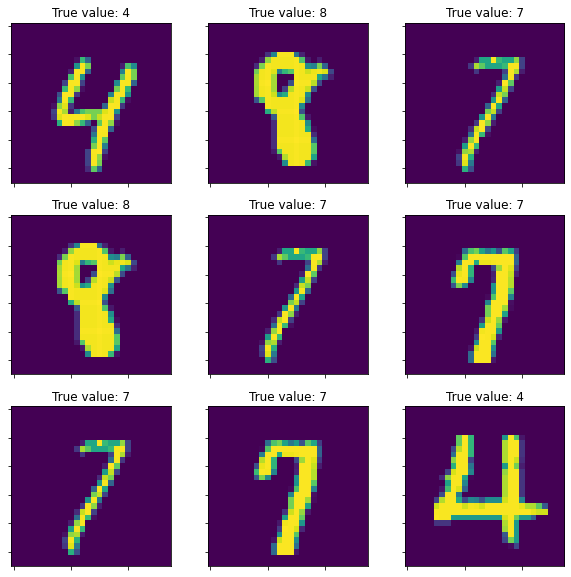

In [9]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        axs[i][j].imshow(images[i + j].reshape(28, 28, 1))
        axs[i][j].set_title(f'True value: {int(labels[i + j])}')
        axs[i][j].set_xticklabels("")
        axs[i][j].set_yticklabels("")

In [10]:
input_size = 784
dense1_size = 256
output_size = 10

In [13]:
import torch
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

def cross_entropy(predictions, targets, epsilon=1e-12):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

lr = 1

tensor_x = torch.tensor(images) / 255.
tensor_y = tensor_labels

W1 = torch.randn(input_size, dense1_size, requires_grad=True)
b1 = torch.randn(dense1_size, requires_grad=True)

W2 = torch.randn(dense1_size, output_size, requires_grad=True)
b2 = torch.randn(output_size, requires_grad=True)

def predict(x):
    dense1_output = x @ W1 + b1
    dense1_activation = F.tanh(dense1_output)

    dense2_output = dense1_activation @ W2 + b2
    dense2_activation = F.softmax(dense2_output, dim=1)
    
    return dense2_activation

for i in range(10):    
    dense1_output = tensor_x @ W1 + b1
    dense1_activation = torch.tanh(dense1_output)

    dense2_output = dense1_activation @ W2 + b2
    prediction = dense2_output
    loss_function = CrossEntropyLoss()
    #loss_function = torch.nn.NLLLoss()

    loss = loss_function(prediction, tensor_y)
    W1.grad = None
    W2.grad = None
    b1.grad = None
    b2.grad = None
    
    loss.backward()
    
    W1.data -= lr * W1.grad
    W2.data -= lr * W2.grad
    b1.data -= lr * b1.grad
    b2.data -= lr * b2.grad
    
    accuracy = list(prediction.argmax(axis=1) == tensor_y.argmax(axis=1)).count(True) / len(tensor_y)
    print(loss.item(), f'{accuracy * 100}%')

27.947547912597656 0.0%
10.845019340515137 53.125%
7.3826212882995605 46.875%
3.2828283309936523 62.5%
1.1169490814208984 90.625%
0.02972486987709999 96.875%
0.00015791767509654164 100.0%
0.00012973036791663617 100.0%
0.0001126051793107763 100.0%
0.00010085239773616195 100.0%


In [37]:
# tutok som to robil cez torch
# teraz spravim manualne parcialne derivacie 💀💀💀
class Loss_MSE:
    def __init__(self):
        self.output = None
        self.doutput = None        

    def forward(self, y, y_pred):
        self.output = np.sum([(y_i - y_pred_i) ** 2 for y_i, y_pred_i in zip(y, y_pred)]) / len(y)
    
    def backward(self, dvalues, y_pred):
        self.doutput = (2 * (y - y_pred)) / len(y)

class Activation_Softmax:
    def __init__(self):
        self.output = None
        self.doutput = None
    
    def forward(self, z):
        z_exp = np.exp(z)
        self.output = [z_exp[i] / np.sum(z_exp[i]) for i in range(len(z_exp))]
    
    def backward(self, ):
        ...
        
        
class Activation_Tanh:
    def __init__(self):
        self.output = None
        self.doutput = None
    
    def forward(self, inpt):
        self.output = np.tanh(inpt)

class Dense_Layer:
    def __init__(self, input_size, num_neurons, activation = 'tanh'):
        self.weights = np.random.randn(input_size, num_neurons)
        self.bias = np.random.randn(1)
        
        self.activation = Activation_Tanh() if activation == 'tanh' else None
        self.output = None
        self.activation_output = None
    
    def forward(self, inpt):
        self.output = inpt @ self.weights + self.bias
        self.activation.forward(self.output)
        self.activation_output = self.activation.output
    
    def backward(self, dinput):
        
    
    
class Model:
    def __init__(self, num_neurons, input_size = 1, activation = 'tanh', loss = 'mse'):
        self.dense = Dense_Layer(input_size, num_neurons, activation = activation)
        self.loss_function = Loss_MSE() if loss == 'mse' else None
        self.loss = None
        self.output = None
    
    # calculate output of the model
    def forward(self, inpt):
        self.dense.forward(inpt)
        self.output = self.dense.activation_output.sum(axis = 1, keepdims=True)
    
    def calculate_loss(self, y, y_pred):
        self.loss_function.forward(y, y_pred)
        self.loss = self.loss_function.output
    
    def backward(self):
        ...
        

In [38]:
f = Activation_Softmax()
x = np.array([[1, 2, 3], [3, 4, 5]])
f.forward(x)

(2, 3)


In [70]:
import torch

x = [[1., 2., 3.]]
w = [[1., 1.], [2., 2.], [3., 3.]]
x_tensor = torch.tensor(x, requires_grad=True)
w_tensor = torch.tensor(w, requires_grad=True)

In [71]:
output = x_tensor @ w_tensor
output_sum = output.sum()

In [72]:
output_sum.backward()

In [73]:
x_tensor.grad

tensor([[2., 4., 6.]])

In [74]:
w_tensor.grad

tensor([[1., 1.],
        [2., 2.],
        [3., 3.]])

In [82]:
output.shape

torch.Size([1, 2])

In [83]:
output

tensor([[14., 14.]], grad_fn=<MmBackward0>)